## BMI/CS 576 Fall 2019 - HW4
The objectives of this homework are to practice

* the Baum–Welch algorithm
* designing HMMs and evaluating their accuracy

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/167969/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually*.

You are welcome to use any code from the weekly notebooks in your solutions to the HW.

## PROBLEM 1: Baum–Welch algorithm (60 points)

For this problem you will implement the Baum–Welch algorithm.  You will implement this algorithm as a set of methods defined for a subclass, `TrainableHMM`, of the HMM class that we have been developing in class.  The high-level master method for this algorithm, `estimate_parameters_baum_welch` is already implemented for you.  This method calls two other methods, corresponding to the Expectation (E) and Maximization (M) steps of the Baum–Welch algorithm, which you are to implement.

The base HMM class that we have implemented in the activities, along with a number of helper functions, are found in the `hmm` module included with this notebook.  You should add your solutions to key methods from your weekly notebooks to it and modify other aspects of it if you wish.  There are a few minor changes in how the HMM class works.  These should not affect how you implement the Baum–Welch algorithm, but will be helpful in improving efficiency for the second problem of this HW.  The changes are:

1. States may now be represented by arbitrary strings, rather than individual characters.  As a result, a state path (such as what is returned by the `most_probable_path` method) is now represented by a *list of strings*.
2. The Viterbi, Forward, and Backward algorithms now take advantage of the sparsity (of non-zero transitions) of the HMM.  This results in efficiency gains, particular for HMMs with large numbers of states but relatively few transitions.  This is important for problem 2.

In [1]:
import hmm
import math
import itertools
from matplotlib import pyplot as plt

class TrainableHMM(hmm.HiddenMarkovModel):

    def estimate_parameters_baum_welch(self, 
                                       training_data, 
                                       pseudocount=0, 
                                       min_log_likelihood_diff=0.1,
                                       verbose=False):
        """Estimates (and sets) the parameters of the model via the Baum–Welch algorithm.
        
        The current parameters of the model will be used as initial parameters.
        Args:
            training_data: A list of strings of observed sequences.
            pseudocount: a pseudocount to add to each expected count when 
                computing the parameter values.  The default is zero, which 
                corresponds to maximimum likelihood estimates without smoothing.
                A value of one corresponds to Laplace smoothing.
            min_log_likelihood_diff: the algorithm will terminate once the 
                difference in the log likelihood of the data from one iteration 
                to the next is less than this value.
            verbose: if True, print progress information during the algorithm.
        """
        # keep track of the log likelihood of the previous iteration
        last_log_likelihood = float("-inf")
        
        # repeat the E and M steps until convergence
        for iteration in itertools.count():
            # E-step
            e_step_results = self.baum_welch_expectation_step(training_data)
            log_likelihood = e_step_results["log_likelihood"]

            # optionally, print log likelihood at current iteration
            if verbose: 
                print("Iteration %d:" % iteration,
                      "log likelihood = %f" % log_likelihood)
            
            # check if difference in log likelihood is sufficiently small to terminate            
            if log_likelihood - last_log_likelihood < min_log_likelihood_diff:
                if log_likelihood < last_log_likelihood:
                    raise RuntimeError("Log likelihood is decreasing! "
                                       "Some calculations must be incorrect.")
                return log_likelihood
    
            # M-step
            self.baum_welch_maximization_step(e_step_results, pseudocount)
            
            last_log_likelihood = log_likelihood

    def baum_welch_expectation_step(self, training_data):
        """Runs the E-step of the Baum–Welch algorithm.
        
        Args:
            training_data: A list of strings of observed sequences.
        Returns:
            A dictionary with the results of the E-step, with the keys:
                log_likelihood: the log probability of the training data given 
                    the current parameters
                transition_count_matrix: a matrix of the same dimensions as 
                    transition_prob_matrix giving the expected counts of
                    each transition
                initial_counts: a list of the same length as initial_probs giving
                    the expected counts of each state starting a hidden path 
                    (expected count of transition from begin state)
                emission_count_matrix: a matrix of the same dimensions as 
                    emission_prob_matrix giving the expected counts of
                    each emission
        """
        # initialize matrices of counts
        transition_count_matrix = hmm.matrix(len(self.states), len(self.states), 0)
        initial_counts = [0] * len(self.states)
        emission_count_matrix = hmm.matrix(len(self.states), len(self.chars), 0)
        
        # initialize log likelihood
        log_likelihood = 0
        
        N = len(self.states)

        # add contribution of each sequence to expected counts and log probability
        for char_string in training_data:
            L = len(char_string)
            f = self.forward_matrix(char_string)
            b = self.backward_matrix(char_string)
            a = self.log_transition_prob_matrix
            e = [[self.log_emission_prob_matrix[i][self.chars.index(char_string[j])] for j in range(L)] for i in range(N)]
            
            log_prob_seq = self.log_probability(char_string, f)
            log_likelihood += log_prob_seq
            
            for i in range(N):
                for j, c in enumerate(self.chars):
                    emission_count_matrix[i][j] += sum(math.exp(f[i][k] + b[i][k] - log_prob_seq) for k in range(L) if char_string[k] == c)
            
            for k in range(N):
                for l in range(N):
                    transition_count_matrix[k][l] += sum(math.exp(f[k][i] + a[k][l] + e[l][i + 1]+ b[l][i + 1] - log_prob_seq) for i in range(L - 1))

            for k in range(N):
                initial_counts[k] += math.exp(f[k][0] + b[k][0] - log_prob_seq)

        # Return results as a dictionary
        return {"log_likelihood": log_likelihood,
                "transition_count_matrix": transition_count_matrix, 
                "initial_counts": initial_counts,
                "emission_count_matrix": emission_count_matrix}
    
    def baum_welch_maximization_step(self, e_step_result, pseudocount=0):
        """Runs the M-step of the Baum–Welch algorithm, updating the parameters of the model.
        
        Args:
            e_step_result: A dictionary of E-step results
                           (see documentation for baum_welch_expectation_step)
            pseudocount: a pseudocount to add to each expected count when 
                computing the parameter values.  The default is zero, which 
                corresponds to maximimum likelihood estimates without smoothing.
                A value of one corresponds to Laplace smoothing.
        """
        transition_count_matrix = e_step_result['transition_count_matrix']
        initial_counts = e_step_result['initial_counts']
        emission_count_matrix = e_step_result['emission_count_matrix']
        
        for i in range(len(self.states)):
            for j in range(len(self.chars)):
                self.emission_prob_matrix[i][j] = emission_count_matrix[i][j] + pseudocount
                
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                self.transition_prob_matrix[i][j] = transition_count_matrix[i][j] + pseudocount
                
        for i in range(len(self.states)):
            self.initial_probs[i] = initial_counts[i] + pseudocount
        
        self.transition_prob_matrix = hmm.normalize_matrix_rows(self.transition_prob_matrix)
        self.initial_probs = hmm.normalize_vector(self.initial_probs)
        self.emission_prob_matrix = hmm.normalize_matrix_rows(self.emission_prob_matrix)
        
        self._compute_log_parameters()

## PROBLEM 2: An exon-intron finding HMM (40 points)

Recall that genes in the genomes of eukaryotic species have substructures called *exons* and *introns*, which are involved in a process called *splicing*.  The splicing process occurs after the initial transcription of the gene from DNA to RNA.  The initial RNA transcript is called a pre-mRNA and contains alternating exon and intron intervals.  A pre-mRNA always starts and ends with an exon and can have any number of introns (including zero, which would be a single-exon pre-mRNA).  During the splicing process, intron intervals are removed and consecutive exon intervals are linked together to form a mature mRNA.  An example of this process is illustrated below:

![intron_exon](intron_exon.png)

For this problem you are to devise and implement an HMM that models pre-mRNA sequences and their exon-intron structures.  You will then train your HMM on a set of pre-mRNA sequences from the fruit fly species *Drosophila melanogaster* using the Baum–Welch algorithm.  With your trained HMM, you will then try to predict the locations of the exons and introns in the same set of pre-mRNA sequences.

**(A)** Draw the state transition diagram (the graph with states as nodes and transitions as edges), for the HMM you devise.  Your HMM should, at a bare minimum, have the following features:
1. One or more states that model *exonic* positions.
2. One or more states that model *intronic* positions.
3. States that enforce that the first two bases of an intron are *always* `GU`
4. States that enforce that the last two bases of an intron are *always* `AG`

You are encouraged to experiment with more complex HMMs to see if you can improve the predictive performance of the model.  For example, you might consider the following features:

1. States modeling the last two bases of an exon and the first six bases of an intron (which make up the "donor" splice site, the signal indicating the start of an intron).  See the notebook from day 10.
2. States modeling the last six bases of an intron and the first base of an exon (which make up the "acceptor" splice site, the signal indicating the end of an intron).
3. Higher-order models of the bases within exons and or introns.  For example, you can model the probability at which each base follows each other base within an exon (instead of each base within an exon being modeled independently).

**(B)** Implement your HMM as an instance of the `TrainableHMM` class and train it (via Baum–Welch) on the fly pre-mRNA sequences provided below.  Print out the estimated parameters of your model.  What statistical properties of exon and intron sequences is your model learning from the data?

**(C)** With your trained model predict the locations of exons and introns within the same set of fly pre-mRNA sequences.  Compute some accuracy measures of your predictions with respect to the true exon-intron annotations provided.  For example, you could compute
1. The base-level accuracy of your predictions: what fraction of the bases within the pre-mRNA sequences are corrected predicted as either exonic or intronic?
2. The feature-level recall of your predictions: what fraction of the true exon (or intron) features are predicted correctly (e.g., for an exon to be predicted correctly, its start and end positions must both be predicted correctly).

**(D)** With your trained model, and one (or more) of the provided pre-mRNA sequences, compute the posterior probability at each position that the position is exonic.  Make a plot of these posterior probabilities (i.e., a plot of the posterior probability of being in an exon vs. position in the sequence).  I recommend using the pyplot function [`fill_between`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.fill_between.html#matplotlib.pyplot.fill_between) for such a plot.

### Fly RNA transcript data
Below are the fly data that you are to use for this problem.  `fly_pre_mrnas` is a list of RNA strings, with each element of the list being the pre-mRNA for a different gene (gene names can be accessed in the corresponding `fly_gene_names` list).  `fly_pre_mrna_annotations` is a corresponding list of the true exon-intron structure of each pre-mRNA.  The structure is specified as a string of the same length as the pre-mRNA consisting of the characters `E` and `I`, indicating which positions of the pre-mRNA are exonic and intronic, respectively.

In [2]:
import fasta
fly_pre_mrna_records = fasta.read_sequences_from_fasta_file("fly_transcripts.fasta")
fly_pre_mrna_annotation_records = fasta.read_sequences_from_fasta_file("fly_transcripts_exon_intron_annotation.fasta")

fly_gene_names, fly_pre_mrnas = zip(*fly_pre_mrna_records)
fly_pre_mrna_annotations = tuple(zip(*fly_pre_mrna_annotation_records))[1]

### Part (A)

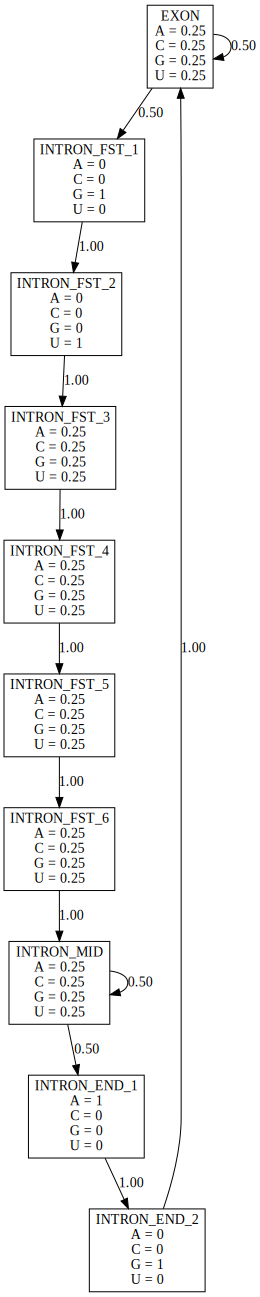

In [6]:
from enum import Enum, auto
from graphviz import Digraph

class State(Enum):
    #                (  A ,   C ,   G ,   U )
    EXON           = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_FST_1   = (   0,    0,    1,    0, auto())
    INTRON_FST_2   = (   0,    0,    0,    1, auto())
    INTRON_FST_3   = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_FST_4   = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_FST_5   = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_FST_6   = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_MID     = (0.25, 0.25, 0.25, 0.25, auto())
    INTRON_END_1   = (   1,    0,    0,    0, auto())
    INTRON_END_2   = (   0,    0,    1,    0, auto())
    

chars = "ACGU"

def init_transition_probs(t):
    return {(u, v) : 1 / sum(e == u for e, _ in t) for u, v in t}

transitions = init_transition_probs([
    (State.EXON, State.INTRON_FST_1),
    (State.EXON, State.EXON),
    
    (State.INTRON_FST_1, State.INTRON_FST_2),
    (State.INTRON_FST_2, State.INTRON_FST_3),
    (State.INTRON_FST_3, State.INTRON_FST_4),
    (State.INTRON_FST_4, State.INTRON_FST_5),
    (State.INTRON_FST_5, State.INTRON_FST_6),
    
    (State.INTRON_FST_6, State.INTRON_MID),
    (State.INTRON_MID, State.INTRON_MID),
    (State.INTRON_MID, State.INTRON_END_1),
    
    (State.INTRON_END_1, State.INTRON_END_2),
    (State.INTRON_END_2, State.EXON),
])


def add_edge(u, v):
    def state_name(state):
        return state.name + "\n" + "\n".join([f"{c} = {p}" for c, p in zip(chars, state.value)])
    
    label = "{0:.2f}".format(1 / sum(e == u for e, _ in transitions))
    g.edge(state_name(u), state_name(v), label=label)

g = Digraph()
g.attr('node', shape='box')

for u, v in transitions:
    add_edge(u, v)

g

### Part (B)

In [95]:
def print_parameters(hmm_instance):
    print("transition_prob_matrix: ")
    hmm.print_matrix(hmm_instance.transition_prob_matrix)
    print("\ninitial_probs: ")
    print(hmm_instance.initial_probs)
    print(f"\nemission_prob_matrix {chars}")
    hmm.print_matrix(hmm_instance.emission_prob_matrix)

exon_intron_hmm = TrainableHMM(
    states=[s.name for s in State],
    chars=chars, 
    transition_prob_matrix=[[transitions.get((u, v), 0) for v in State] for u in State], 
    initial_probs=[0.5, 0.5] + [0] * (len(State) - 2),
    emission_prob_matrix=[list(s.value[:-1]) for s in State]
)

In [96]:
print("============================== Initial Parameters ==============================")
print_parameters(exon_intron_hmm)

print("============================== Estimating Parameters ==============================")
exon_intron_hmm.estimate_parameters_baum_welch(fly_pre_mrnas, verbose=True)

print("============================== Trained Parameters ==============================")
print_parameters(exon_intron_hmm)

============================== Initial Parameters ==============================
transition_prob_matrix: 
       0.5       0.5         0         0         0         0         0         0         0         0
         0         0         1         0         0         0         0         0         0         0
         0         0         0         1         0         0         0         0         0         0
         0         0         0         0         1         0         0         0         0         0
         0         0         0         0         0         1         0         0         0         0
         0         0         0         0         0         0         1         0         0         0
         0         0         0         0         0         0         0         1         0         0
         0         0         0         0         0         0         0       0.5       0.5         0
         0         0         0         0         0         0         0         0      

#### From the initial probabilities, we can see that it is highly unlikely that the first base in the sequence is intronic since the initial probability for intron is only 0.9091913108742553. 

#### For exon state, the likelyhood for all four bases are roughly the same, with base U slightly higher (26.2%) than others (25.8% for A, and 24.1 for C, and 24% for G)

#### The thrid and fourth bases in an intron are more likely to be an A (51.7% for third, and 61.3 for fourth)

#### The fifth bases in an intron are more likely to be an G (57.3%)

#### The sixth bases in an intron are more likely to be an U (60.9%)

#### The middle bases (other than first 6 or ending 2) in an intron are more likely to be an A (34.5%) or U (36.4%)

### Part (C)

In [50]:
def compute_accuracy(exon_intron_hmm):
    def state_to_annotation(path):
        return "".join(p[0] for p in path)
    
    def annotation_to_exon_pair(annotation):
        l = []
        if annotation[0] == 'E':
            l += [0]
            
        for i, (a, b) in enumerate(zip(annotation, annotation[1:])):
            if (a, b) == ("E", "I"):
                l += [i]
            elif (a, b) == ("I", "E"):
                l += [i + 1]
            
        if annotation[len(annotation) - 1] == 'E':
            l += [len(annotation) - 1]
        
        return [(l[i], l[i + 1]) for i in range(0, len(l), 2)]
    
    def compute_feature_accuracy(expected_annotation, actual_annotation):
        expected_pair = annotation_to_exon_pair(expected_annotation)
        actual_pair = annotation_to_exon_pair(actual_annotation)
        return sum(p in expected_pair for p in actual_pair) / len(expected_pair)
        

    base_accuracy = 0
    feature_accuracy = 0
    for mrna, expected_annotation in zip(fly_pre_mrnas, fly_pre_mrna_annotations):
        path = exon_intron_hmm.most_probable_path(mrna)
        actual_annotation = state_to_annotation(path)
        
        base_accuracy += sum(e == a for e, a in zip(expected_annotation, actual_annotation)) / len(mrna)
        feature_accuracy += compute_feature_accuracy(expected_annotation, actual_annotation)
        
    base_accuracy /= len(fly_pre_mrnas)
    feature_accuracy /= len(fly_pre_mrnas)
    
    print(f"base_accuracy = {base_accuracy}")
    print(f"feature_accuracy = {feature_accuracy}")
        
    
compute_accuracy(exon_intron_hmm)    

base_accuracy = 0.8093742491880687
feature_accuracy = 0.26517857142857143


### Part (D)

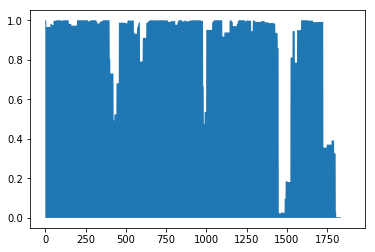

In [94]:
def plot_posterior_probabilities(mrna):
    is_state_exonic = [s.name[0] == 'E' for s in State]
    prob = [0] * len(mrna)
    
    for i, row in enumerate(exon_intron_hmm.posterior_matrix(mrna)):
        if not is_state_exonic[i]:
            continue
        for i, val in enumerate(row):
            prob[i] += val
    
    plt.fill_between(list(range(len(mrna))), prob)

plot_posterior_probabilities(fly_pre_mrnas[0])


## Models for testing

### Coin flipping model

In [26]:
# A coin flipping model like the casino model below, but with two
# potentially biased coin states that emit either heads or tails
coin_states = "12" # 1 = coin 1, 2 = coin 2
coin_chars = "HT"  # heads or tails
coin_initial_probs = [0.5, 0.5]
coin_transition_prob_matrix = [
    [0.8, 0.2],
    [0.3, 0.7]
]
coin_emission_prob_matrix = [
    [0.9, 0.1],
    [0.4, 0.6]
]
coin_hmm = TrainableHMM(coin_states,
                        coin_chars,
                        coin_transition_prob_matrix,
                        coin_initial_probs,
                        coin_emission_prob_matrix)

# A micro example with this model
coin_micro_dataset = ["T"]

# A tiny example with this model
coin_tiny_dataset = ["TH"]

### Coin flipping model - micro tests (30 POINTS)

In [27]:
# tests for coin micro expected emission_counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_micro_dataset)
assert hmm.round_matrix(e_step_results["emission_count_matrix"], 3) == [[0, 0.143], [0, 0.857]]
print("SUCCESS: coin micro expected emission counts test passed")

SUCCESS: coin micro expected emission counts test passed


In [28]:
# tests for coin micro expected transition_counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_micro_dataset)
assert hmm.round_matrix(e_step_results["transition_count_matrix"], 3) == [[0, 0], [0, 0]]
print("SUCCESS: coin micro expected transition counts test passed")

SUCCESS: coin micro expected transition counts test passed


In [29]:
# tests for coin micro expected initial counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_micro_dataset)
assert hmm.round_vector(e_step_results["initial_counts"], 3) == [0.143, 0.857]
print("SUCCESS: coin micro expected initial counts test passed")

SUCCESS: coin micro expected initial counts test passed


In [30]:
# tests for coin micro log likelihood
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_micro_dataset)
assert round(e_step_results["log_likelihood"], 3) == -1.05
print("SUCCESS: coin micro log likelihood test passed")

SUCCESS: coin micro log likelihood test passed


In [31]:
# tests for coin micro M-step
e_step_results = {
    "transition_count_matrix": [[0, 0], 
                                [0, 0]],
    "initial_counts": [0.14285714285714288, 0.8571428571428572],
    "emission_count_matrix": [[0, 0.14285714285714288], 
                              [0, 0.8571428571428572]],
    "log_likelihood": -1.0498221244986776}

pseudocount = 1
coin_hmm.baum_welch_maximization_step(e_step_results, pseudocount)
assert hmm.round_matrix(coin_hmm.transition_prob_matrix, 3) == [[0.5, 0.5], [0.5, 0.5]]
assert hmm.round_vector(coin_hmm.initial_probs, 3) == [0.381, 0.619]
assert hmm.round_matrix(coin_hmm.emission_prob_matrix, 3) == [[0.467, 0.533], [0.35, 0.65]]
print("SUCCESS: coin micro M-step test passed")

SUCCESS: coin micro M-step test passed


### Coin flipping model - tiny tests (10 POINTS)

In [32]:
# tests for coin tiny expected emission_counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_tiny_dataset)
assert hmm.round_matrix(e_step_results["emission_count_matrix"], 3) == [[0.571, 0.195], [0.429, 0.805]]
print("SUCCESS: coin tiny expected emission counts test passed")

SUCCESS: coin tiny expected emission counts test passed


In [33]:
# tests for coin tiny expected transition_counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_tiny_dataset)
assert hmm.round_matrix(e_step_results["transition_count_matrix"], 3) == [[0.176, 0.02], [0.395, 0.41]]
print("SUCCESS: coin tiny expected transition counts test passed")

SUCCESS: coin tiny expected transition counts test passed


In [34]:
# tests for coin tiny expected initial counts
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_tiny_dataset)
assert hmm.round_vector(e_step_results["initial_counts"], 3) == [0.195, 0.805]
print("SUCCESS: coin tiny expected initial counts test passed")

SUCCESS: coin tiny expected initial counts test passed


In [35]:
# tests for coin tiny log likelihood
coin_hmm.set_parameters(coin_transition_prob_matrix, coin_initial_probs, coin_emission_prob_matrix)
e_step_results = coin_hmm.baum_welch_expectation_step(coin_tiny_dataset)
assert round(e_step_results["log_likelihood"], 3) == -1.585
print("SUCCESS: coin tiny log likelihood test passed")

SUCCESS: coin tiny log likelihood test passed


In [36]:
# tests for coin tiny M-step
e_step_results = {
    "transition_count_matrix":[[0.175609756097561, 0.019512195121951226], 
                               [0.3951219512195122, 0.4097560975609756]],
    "initial_counts":        [0.19512195121951223, 0.8048780487804876],
    "emission_count_matrix": [[0.5707317073170731, 0.19512195121951223], 
                              [0.4292682926829269, 0.8048780487804876]],
    "log_likelihood": -1.5847452998437288}
pseudocount = 0
coin_hmm.baum_welch_maximization_step(e_step_results, pseudocount)
assert hmm.round_matrix(coin_hmm.transition_prob_matrix, 3) == [[0.9, 0.1], [0.491, 0.509]]
assert hmm.round_vector(coin_hmm.initial_probs, 3) == [0.195, 0.805]
assert hmm.round_matrix(coin_hmm.emission_prob_matrix, 3) == [[0.745, 0.255], [0.348, 0.652]]
print("SUCCESS: coin tiny M-step test passed")

SUCCESS: coin tiny M-step test passed


### Occasionally dishonest casino tests (10 POINTS)

In [37]:
# The occasionally dishonest casino example described in the lecture and textbook
casino_states = "FL"     # F = fair die, L = loaded die
casino_chars = "123456"  # the six sides of the die
casino_initial_probs = [0.5, 0.5]
casino_transition_prob_matrix = [
    [0.95, 0.05],
    [0.10, 0.90]
]
casino_emission_prob_matrix = [
    [ 1/6,  1/6,  1/6,  1/6,  1/6, 1/6],
    [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]
]
casino_hmm = TrainableHMM(casino_states, 
                          casino_chars, 
                          casino_transition_prob_matrix, 
                          casino_initial_probs,
                          casino_emission_prob_matrix)

casino_sequences = ["165", "63"]

In [38]:
# tests for casino expected emission counts
casino_hmm.set_parameters(casino_transition_prob_matrix, casino_initial_probs, casino_emission_prob_matrix)
e_step_results = casino_hmm.baum_welch_expectation_step(casino_sequences)
assert hmm.round_matrix(e_step_results["emission_count_matrix"], 3) == \
    [[0.484, 0, 0.431, 0, 0.535, 0.804], 
     [0.516, 0, 0.569, 0, 0.465, 1.196]]
print("SUCCESS: casino expected emission counts test passed")

SUCCESS: casino expected emission counts test passed


In [39]:
# tests for casino expected transition counts
casino_hmm.set_parameters(casino_transition_prob_matrix, casino_initial_probs, casino_emission_prob_matrix)
e_step_results = casino_hmm.baum_welch_expectation_step(casino_sequences)
log_likelihood, transition_count_matrix, initial_counts, emission_count_matrix = e_step_results
assert hmm.round_matrix(e_step_results["transition_count_matrix"], 3) == \
    [[1.218, 0.07], [0.215, 1.497]]
print("SUCCESS: casino expected transition counts test passed")

SUCCESS: casino expected transition counts test passed


In [40]:
# tests for casino expected initial counts
casino_hmm.set_parameters(casino_transition_prob_matrix, casino_initial_probs, casino_emission_prob_matrix)
e_step_results = casino_hmm.baum_welch_expectation_step(casino_sequences)
assert hmm.round_vector(e_step_results["initial_counts"], 3) == [0.822, 1.178]
print("SUCCESS: casino expected initial counts test passed")

SUCCESS: casino expected initial counts test passed


In [41]:
# tests for casino log likelihood
casino_hmm.set_parameters(casino_transition_prob_matrix, casino_initial_probs, casino_emission_prob_matrix)
e_step_results = casino_hmm.baum_welch_expectation_step(casino_sequences)
assert round(e_step_results["log_likelihood"], 3) == -8.528
print("SUCCESS: casino log likelihood test passed")

SUCCESS: casino log likelihood test passed


In [42]:
# tests for casino M-step
e_step_results = {
    "transition_count_matrix": [[1.2182391796657972, 0.06984732452392478],
                                [0.21453844829210775, 1.497375047518171]],
    "initial_counts": [0.8217716073650729, 1.178228392634928],
    "emission_count_matrix": [
        [0.48384057288231425, 0, 0.4310344827586207, 0, 0.5354282483746345, 0.8042459313074077],
        [0.5161594271176861, 0, 0.5689655172413794, 0, 0.46457175162536557, 1.1957540686925925]]
}

pseudocount = 0
casino_hmm.baum_welch_maximization_step(e_step_results, pseudocount)
assert hmm.round_matrix(casino_hmm.transition_prob_matrix, 3) == [[0.946, 0.054], [0.125, 0.875]]
assert hmm.round_vector(casino_hmm.initial_probs, 3) == [0.411, 0.589]
assert hmm.round_matrix(casino_hmm.emission_prob_matrix, 3) == [[0.215, 0.0, 0.191, 0.0, 0.237, 0.357],
                                                                [0.188, 0.0, 0.207, 0.0, 0.169, 0.436]]
print("SUCCESS: casino M-step test passed")

SUCCESS: casino M-step test passed


### CpG model tests (10 POINTS)

In [43]:
# The CpG HMM example described in the lecture and textbook
cpg_states = ["A+", "C+", "G+", "T+", # CpG states
              "A-", "C-", "G-", "T-"] # Null states
cpg_chars = "ACGT"

cpg_initial_probs = [1 / len(cpg_states)] * len(cpg_states)

cpg_transition_prob_matrix = hmm.matrix(len(cpg_states), len(cpg_states))
for i in range(len(cpg_states)):
    for j in range(len(cpg_states)):
        same_class = cpg_states[i][-1] == cpg_states[j][-1]
        cpg_transition_prob_matrix[i][j] = 0.2 if same_class else 0.05
# modify transition probs from C- to model having fewer CpG in null
cpg_transition_prob_matrix[cpg_states.index("C-")][cpg_states.index("A-")] = 0.25
cpg_transition_prob_matrix[cpg_states.index("C-")][cpg_states.index("C-")] = 0.25
cpg_transition_prob_matrix[cpg_states.index("C-")][cpg_states.index("G-")] = 0.05
cpg_transition_prob_matrix[cpg_states.index("C-")][cpg_states.index("T-")] = 0.25

cpg_emission_prob_matrix = hmm.matrix(len(cpg_states), len(cpg_chars))
for i in range(len(cpg_states)):
    for j in range(len(cpg_chars)):
        char_matches_state = cpg_states[i][0] == cpg_chars[j]
        cpg_emission_prob_matrix[i][j] = 1 if char_matches_state else 0

cpg_hmm = TrainableHMM(cpg_states, 
                       cpg_chars, 
                       cpg_transition_prob_matrix, 
                       cpg_initial_probs,
                       cpg_emission_prob_matrix)

cpg_dataset = [
    'CCTTGATTAAATGAGGAAAGTGCTATCATGTTTGTCCCTACAATCTTGCTCGCAGCCGCATGGTATCCCCAATTCCGGCT',
    'CCAGGAAGTAGACTCTTCTGCGGCGAGAGGGGGGCCGGAGCATGGCTCAGGTCACATGAGCGATGTCAACTAGTGCGAGT',
    'TTATTGGCCTACGAAAATCTACAAGAGGTTTTGACAGTTGTGAGAATCGGGCGGTACCACTCATCGATAGGGCTGAGCAT',
    'GGGGTCTATGGCGGCGAGTCCGTCTAATTACTGACAGGGCAGGTCTTATGGCCGACGGTAAACCATGCACGCACCGGGGT',
    'ATTGATGCCCGGATGAGGGCGCGACCCAAGACATCGACATCAAGTGGAACAGCGAGTCTCTTGTCATCAGGGCGGCCCCC',
    'AACTACTCCTATGTTATGGTCTCGGAGGGAATTCCACCAATTAGCTGGGAAGCAGCCCCATTTTGCTTCAACTAATTCGA',
    'CTAGCTCCACTGACGGGTGTATTCAGCCGTACTAATATCGGGACTACCAGCCTGTCTTGACCGCAGCTGGCCGACCTAAC',
    'AGTATTGAACGTTTAACTCTCAGGACAGGGCGTCTGCATTCTGTTCACATACTGTAAATGAGCAATATCCTTTTTGAGTC',
    'TCGTTTGTAGGTGTGAGACTTCCTAAGGTACAGGATAGCTTATTTGGGAGAATACCTTCCACCTCTGCATCCAGGCTATC',
    'TCCCTGTGTGTTAGCGAAAATTATGGTTACAAGCATCCAATACAACTTTCATCTCCAAGCTAGTCGTAAAAGCTGATAAA']

In [44]:
# tests for cpg expected emission counts
cpg_hmm.set_parameters(cpg_transition_prob_matrix, cpg_initial_probs, cpg_emission_prob_matrix)
e_step_results = cpg_hmm.baum_welch_expectation_step(cpg_dataset)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [45]:
# tests for cpg expected transition counts
cpg_hmm.set_parameters(cpg_transition_prob_matrix, cpg_initial_probs, cpg_emission_prob_matrix)
e_step_results = cpg_hmm.baum_welch_expectation_step(cpg_dataset)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
# tests for cpg expected initial counts
cpg_hmm.set_parameters(cpg_transition_prob_matrix, cpg_initial_probs, cpg_emission_prob_matrix)
e_step_results = cpg_hmm.baum_welch_expectation_step(cpg_dataset)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
# tests for cpg log likelihood
cpg_hmm.set_parameters(cpg_transition_prob_matrix, cpg_initial_probs, cpg_emission_prob_matrix)
e_step_results = cpg_hmm.baum_welch_expectation_step(cpg_dataset)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
# tests for cpg M-step
###
### AUTOGRADER TEST - DO NOT REMOVE
###
